In [2]:
import numpy
import matplotlib
import torch
import shutil

Проверка на наличие граф.процессора

In [3]:
torch.cuda.is_available()

False

In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
#about torch...
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

#using numpy
import numpy as np

#for data load or save
import pandas as pd

#visualize some datasets
import matplotlib.pyplot as plt

#check our work directory
import os

#to unzip datasets
import zipfile

In [6]:
lr = 0.001 # learning_rate
batch_size = 100 # we will use mini-batch method
epochs = 10 # How much to train a model

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

print(device)

cpu


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Пункт 1-2 
##Загрузка данных и разделение на папки

In [9]:
if os.path.isdir('data'):
        shutil.rmtree('data')
os.makedirs('data', exist_ok=True)
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/test', exist_ok=True)
os.makedirs('data/validation', exist_ok=True)

In [10]:
base_dir = "/content/drive/MyDrive"
with zipfile.ZipFile(os.path.join(base_dir, 'dataset_all_names.zip')) as train_zip:
        train_zip.extractall('data')

In [11]:
list_of_something = os.listdir('data/dataset_all_names')
for el in list_of_something:
  way = 'data/dataset_all_names/' + str(el)
  shutil.move(way, 'data/train')
shutil.rmtree('data/dataset_all_names')

In [12]:
list_train = os.listdir('data/train')

list_test = list_train[:100] + list_train[-100:]
del list_train[:100]
del list_train[-100:]

list_validation = list_train[:100] + list_train[-100:]
del list_train[:100]
del list_train[-100:]

In [13]:
for elem in list_test:
        shutil.move("data/train/" + str(elem), "data/test")
for elem in list_validation:
        shutil.move("data/train/" + str(elem), "data/validation")

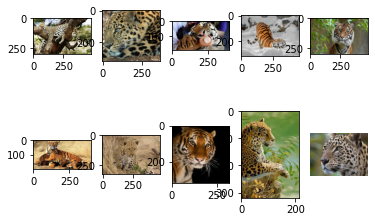

In [14]:
from PIL import Image
random_idx = np.random.randint(1, 200, size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    way_to_file = "data/train/" + str(list_train[idx])
    img = Image.open(way_to_file)
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

# Пункт 3
## Пайплайн предобработки данных 

In [15]:
#data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [16]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        way_to_file = "data/train/" + str(list_train[idx])
        img = Image.open(way_to_file)
        img_transformed = self.transform(img)
        
        label1 = str(list_train[idx]).split('_')[0]
        if label1 == 'tiger':
            label=0
        elif label1 == 'leopard':
            label=1
            
        return img_transformed,label

In [17]:
train_data = dataset(list_train, transform=train_transforms)
test_data = dataset(list_test, transform=test_transforms)
val_data = dataset(list_validation, transform=test_transforms)

In [18]:
from torch.utils.data import DataLoader

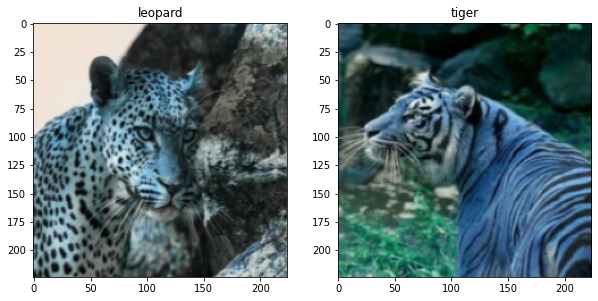

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("tiger" if train_data[110][1] == 0 else "leopard")
plt.imshow(train_data[110][0].permute(1, 2, 0).numpy()[:, :, ::-1])
plt.subplot(1, 2, 2)
plt.title("tiger" if train_data[10][1] == 0 else "leopard")
plt.imshow(train_data[10][0].permute(1, 2, 0).numpy()[:, :, ::-1])

In [20]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Пункт 4
## модель сверточной нейронной сети

build Model

3 Convolution layer and 2 fully connected layer
batchNormalization for limit overfitting

# Пункт 5 
## Цикл обучения

set Loss function and optimizer

In [21]:
lr = 0.001 # learning_rate
batch_size = 100 # we will use mini-batch method

In [22]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=100, shuffle=True)

In [23]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
train_data[0][0].shape

1598 16
200 2


torch.Size([3, 224, 224])

In [24]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,1)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.Flatten()(out)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return torch.nn.Sigmoid()(out)

In [25]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (re

In [26]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.BCELoss()

In [27]:
accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

def train_loop(train_loader, val_loader):
    epochs = 10
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())
        
        model.eval()
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label.unsqueeze(dim=1).to(torch.float))
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        val_accuracy_values.append(epoch_val_accuracy.item())
        val_loss_values.append(epoch_val_loss.item())
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
        print('\n')


In [28]:
train_loop(train_loader, val_loader)

Epoch : 1, train accuracy : 0.5050382614135742, train loss : 0.68686443567276
Epoch : 1, val_accuracy : 0.5349999666213989, val_loss : 0.6888346672058105


Epoch : 2, train accuracy : 0.5050637722015381, train loss : 0.6895458698272705
Epoch : 2, val_accuracy : 0.5349999666213989, val_loss : 0.6869543194770813


Epoch : 3, train accuracy : 0.5050637722015381, train loss : 0.6816731691360474
Epoch : 3, val_accuracy : 0.5349999666213989, val_loss : 0.6872804164886475


Epoch : 4, train accuracy : 0.5050765872001648, train loss : 0.6718082427978516
Epoch : 4, val_accuracy : 0.5349999666213989, val_loss : 0.6580577492713928


Epoch : 5, train accuracy : 0.5050128102302551, train loss : 0.6328410506248474
Epoch : 5, val_accuracy : 0.5349999666213989, val_loss : 0.6079918146133423


Epoch : 6, train accuracy : 0.5049999356269836, train loss : 0.5759128928184509
Epoch : 6, val_accuracy : 0.5349999666213989, val_loss : 0.5190067887306213


Epoch : 7, train accuracy : 0.50507652759552, train lo

In [29]:
accuracy_values

[0.5050382614135742,
 0.5050637722015381,
 0.5050637722015381,
 0.5050765872001648,
 0.5050128102302551,
 0.5049999356269836,
 0.50507652759552,
 0.5049107074737549,
 0.5050127506256104,
 0.5049872398376465]

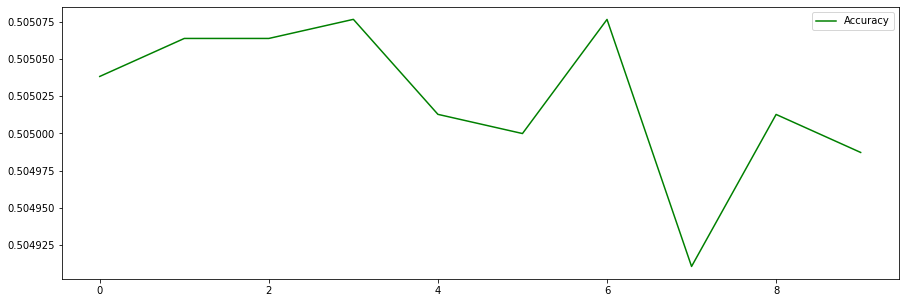

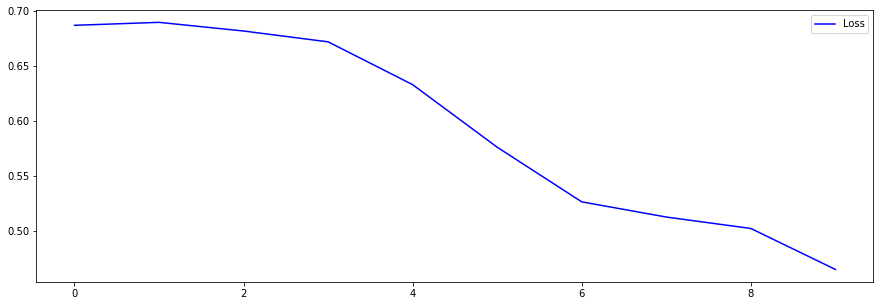

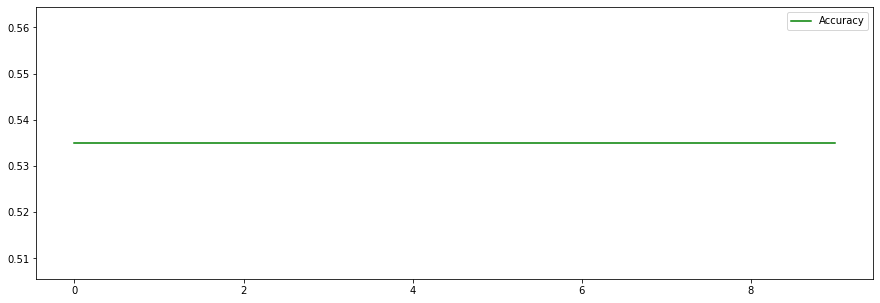

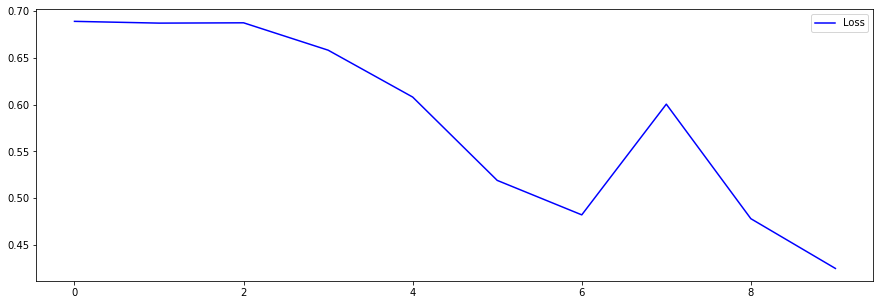

In [30]:
plt.figure(figsize=(15, 5))
plt.plot(accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 
    


plt.figure(figsize=(15, 5))
plt.plot(val_accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(val_loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 
    
    

# Пункт 6
## Эксперименты обучения 


In [31]:
lear = 0.001
batch_size = 50

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

Epoch : 1, train accuracy : 0.5050000548362732, train loss : 0.465032696723938
Epoch : 1, val_accuracy : 0.5349999666213989, val_loss : 0.4802461862564087


Epoch : 2, train accuracy : 0.5049999952316284, train loss : 0.44889751076698303
Epoch : 2, val_accuracy : 0.5349999666213989, val_loss : 0.41320306062698364


Epoch : 3, train accuracy : 0.5048956871032715, train loss : 0.41657811403274536
Epoch : 3, val_accuracy : 0.5349999666213989, val_loss : 0.4457126259803772


Epoch : 4, train accuracy : 0.5050780773162842, train loss : 0.3699401021003723
Epoch : 4, val_accuracy : 0.5349999666213989, val_loss : 0.402587354183197


Epoch : 5, train accuracy : 0.504895806312561, train loss : 0.37178653478622437
Epoch : 5, val_accuracy : 0.5349999666213989, val_loss : 0.32348135113716125


Epoch : 6, train accuracy : 0.5048697590827942, train loss : 0.3616536557674408
Epoch : 6, val_accuracy : 0.5349999666213989, val_loss : 0.3029039204120636


Epoch : 7, train accuracy : 0.5049479603767395, tr

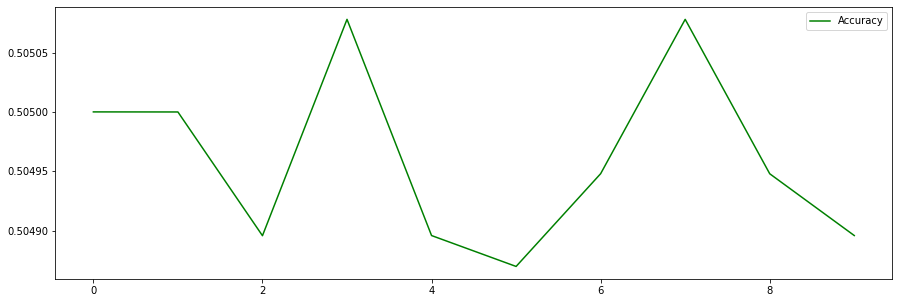

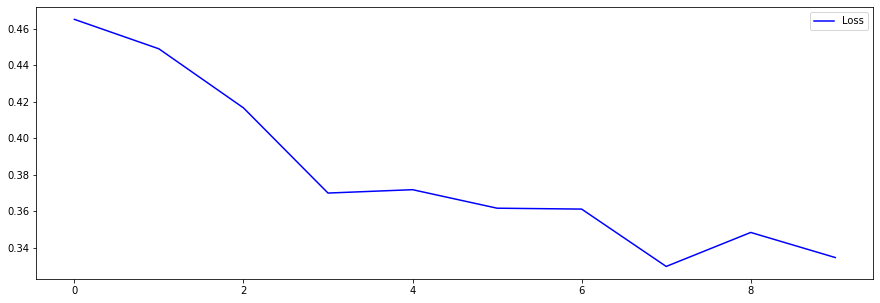

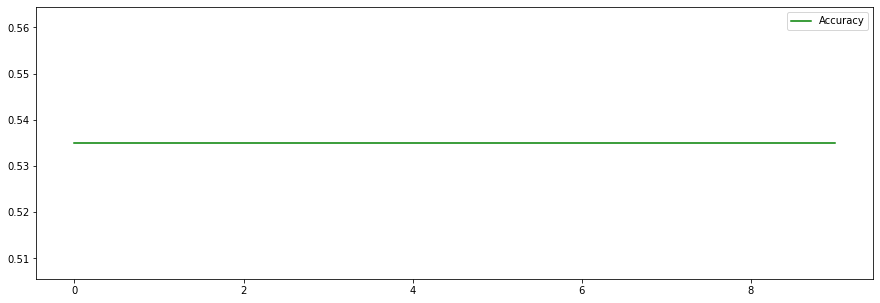

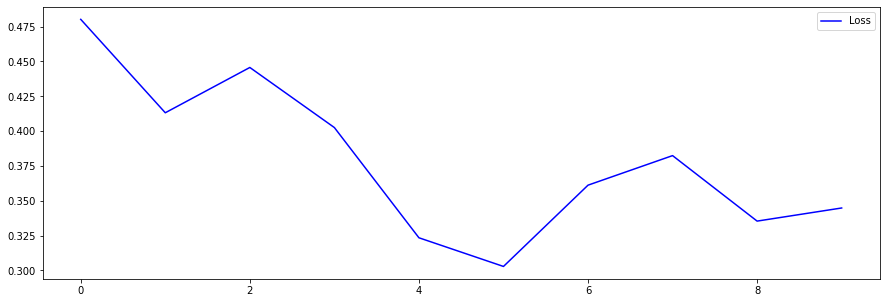

In [32]:
plt.figure(figsize=(15, 5))
plt.plot( accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot( loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 
    
plt.figure(figsize=(15, 5))
plt.plot( val_accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(val_loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 

In [33]:
lear = 0.001
batch_size = 200

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

Epoch : 1, train accuracy : 0.5049999952316284, train loss : 0.3310081958770752
Epoch : 1, val_accuracy : 0.5350000262260437, val_loss : 0.29970940947532654


Epoch : 2, train accuracy : 0.5050504803657532, train loss : 0.3780023455619812
Epoch : 2, val_accuracy : 0.5350000262260437, val_loss : 0.3735225200653076


Epoch : 3, train accuracy : 0.5049747228622437, train loss : 0.32439419627189636
Epoch : 3, val_accuracy : 0.5350000262260437, val_loss : 0.31939977407455444


Epoch : 4, train accuracy : 0.5049999952316284, train loss : 0.31866076588630676
Epoch : 4, val_accuracy : 0.5350000262260437, val_loss : 0.31516289710998535


Epoch : 5, train accuracy : 0.5049620866775513, train loss : 0.3099088966846466
Epoch : 5, val_accuracy : 0.5350000262260437, val_loss : 0.27329662442207336


Epoch : 6, train accuracy : 0.505018949508667, train loss : 0.29652076959609985
Epoch : 6, val_accuracy : 0.5350000262260437, val_loss : 0.28254297375679016


Epoch : 7, train accuracy : 0.504974782466888

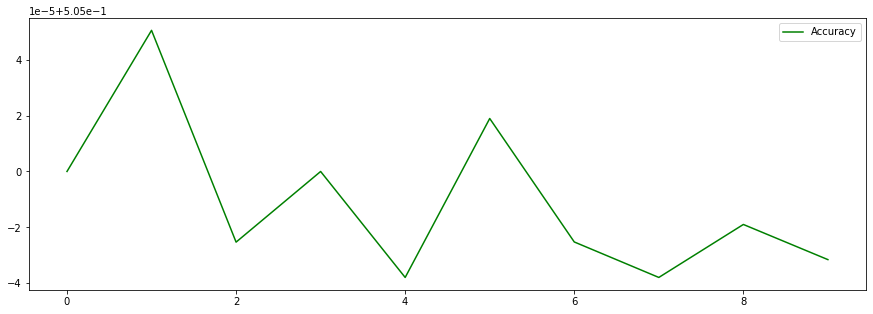

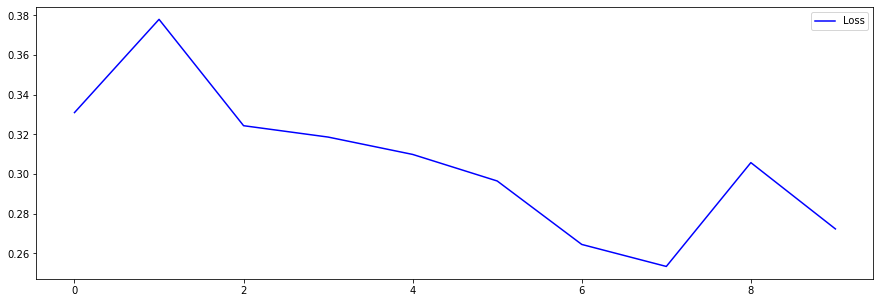

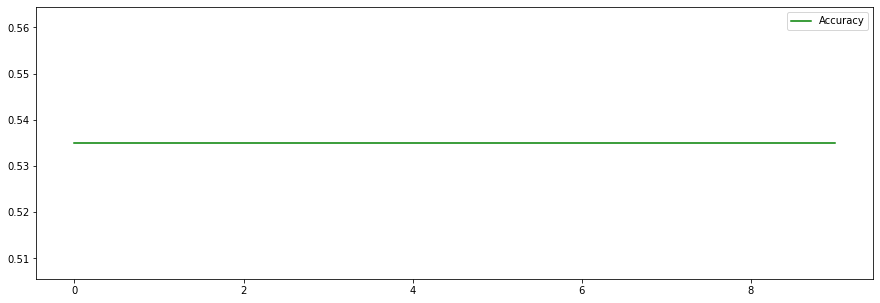

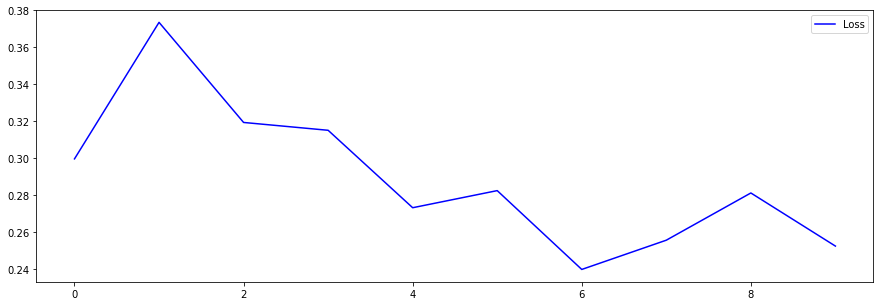

In [34]:
plt.figure(figsize=(15, 5))
plt.plot( accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot( loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 
    
plt.figure(figsize=(15, 5))
plt.plot( val_accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(val_loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 

In [35]:
lear = 0.0005
batch_size = 50

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

Epoch : 1, train accuracy : 0.505104124546051, train loss : 0.2934330701828003
Epoch : 1, val_accuracy : 0.5349999666213989, val_loss : 0.24212181568145752


Epoch : 2, train accuracy : 0.5050520300865173, train loss : 0.2779426574707031
Epoch : 2, val_accuracy : 0.5349999666213989, val_loss : 0.31694769859313965


Epoch : 3, train accuracy : 0.505104124546051, train loss : 0.3101193606853485
Epoch : 3, val_accuracy : 0.5349999666213989, val_loss : 0.2731156349182129


Epoch : 4, train accuracy : 0.5048957467079163, train loss : 0.2614494264125824
Epoch : 4, val_accuracy : 0.5349999666213989, val_loss : 0.2825820744037628


Epoch : 5, train accuracy : 0.5049217939376831, train loss : 0.2587142586708069
Epoch : 5, val_accuracy : 0.5349999666213989, val_loss : 0.2190459817647934


Epoch : 6, train accuracy : 0.50502610206604, train loss : 0.2606296241283417
Epoch : 6, val_accuracy : 0.5349999666213989, val_loss : 0.27778568863868713


Epoch : 7, train accuracy : 0.5050780773162842, train

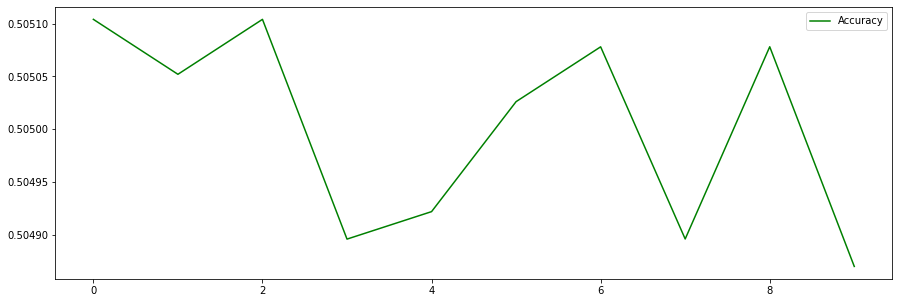

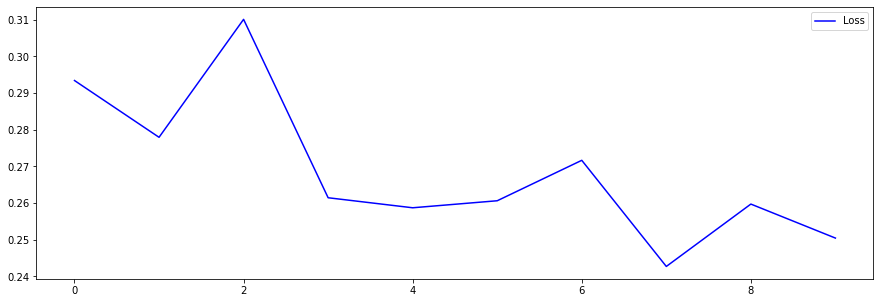

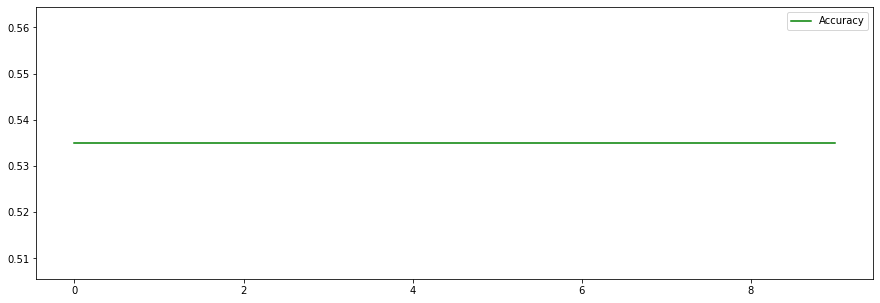

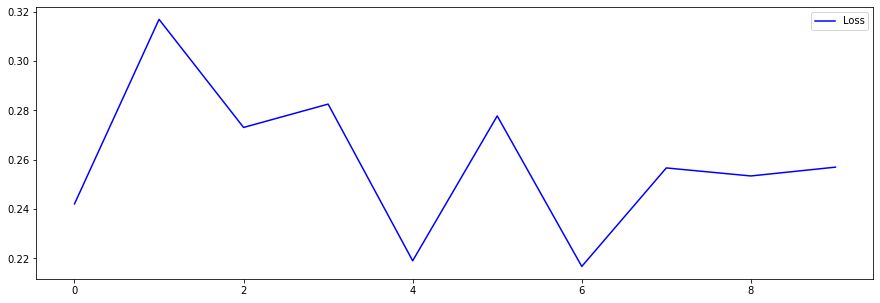

In [36]:
plt.figure(figsize=(15, 5))
plt.plot( accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot( loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 
    
plt.figure(figsize=(15, 5))
plt.plot( val_accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(val_loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 

In [37]:
lear = 0.0005
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)


Epoch : 1, train accuracy : 0.5051147937774658, train loss : 0.24931928515434265
Epoch : 1, val_accuracy : 0.5349999666213989, val_loss : 0.2867104709148407


Epoch : 2, train accuracy : 0.5049744844436646, train loss : 0.2693305015563965
Epoch : 2, val_accuracy : 0.5349999666213989, val_loss : 0.2718098759651184


Epoch : 3, train accuracy : 0.5049999952316284, train loss : 0.24627892673015594
Epoch : 3, val_accuracy : 0.5349999666213989, val_loss : 0.24249069392681122


Epoch : 4, train accuracy : 0.5050382614135742, train loss : 0.24165481328964233
Epoch : 4, val_accuracy : 0.5349999666213989, val_loss : 0.21940934658050537


Epoch : 5, train accuracy : 0.5049107074737549, train loss : 0.22933748364448547
Epoch : 5, val_accuracy : 0.5349999666213989, val_loss : 0.25548434257507324


Epoch : 6, train accuracy : 0.5049999952316284, train loss : 0.2565256655216217
Epoch : 6, val_accuracy : 0.5349999666213989, val_loss : 0.2426454722881317


Epoch : 7, train accuracy : 0.504999995231628

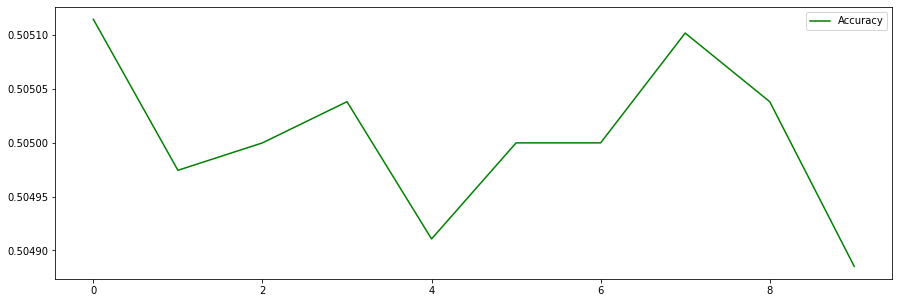

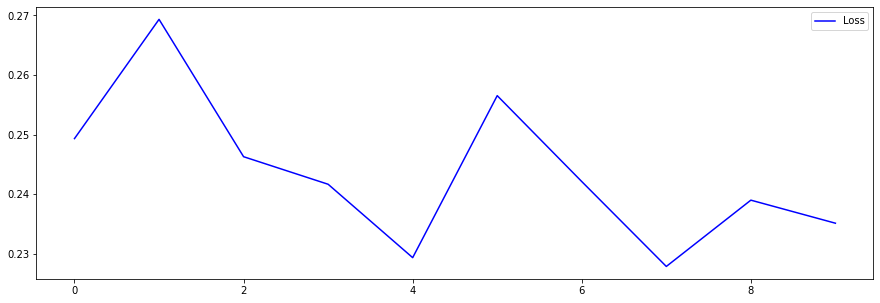

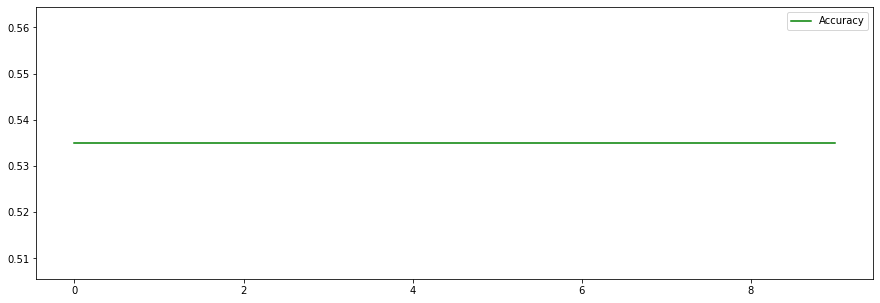

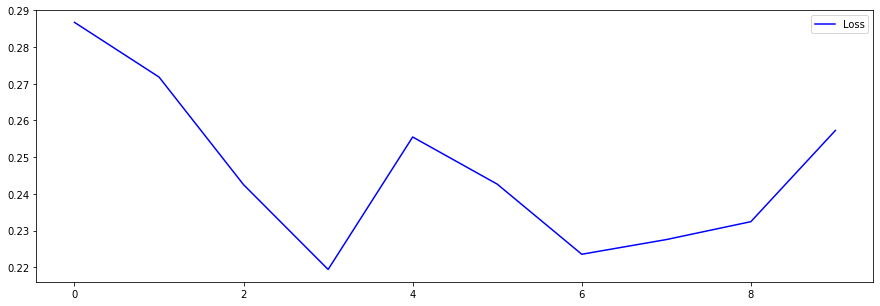

In [38]:
plt.figure(figsize=(15, 5))
plt.plot( accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot( loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 
    
plt.figure(figsize=(15, 5))
plt.plot( val_accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(val_loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 

In [39]:
lear = 0.0005
batch_size = 200

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

Epoch : 1, train accuracy : 0.505018949508667, train loss : 0.2494552731513977
Epoch : 1, val_accuracy : 0.5350000262260437, val_loss : 0.2178981453180313


Epoch : 2, train accuracy : 0.505018949508667, train loss : 0.20801810920238495
Epoch : 2, val_accuracy : 0.5350000262260437, val_loss : 0.20171970129013062


Epoch : 3, train accuracy : 0.5049874186515808, train loss : 0.22152118384838104
Epoch : 3, val_accuracy : 0.5350000262260437, val_loss : 0.2448367178440094


Epoch : 4, train accuracy : 0.5049999952316284, train loss : 0.22539138793945312
Epoch : 4, val_accuracy : 0.5350000262260437, val_loss : 0.21518872678279877


Epoch : 5, train accuracy : 0.5050252676010132, train loss : 0.2071782797574997
Epoch : 5, val_accuracy : 0.5350000262260437, val_loss : 0.18114812672138214


Epoch : 6, train accuracy : 0.5050757527351379, train loss : 0.23162181675434113
Epoch : 6, val_accuracy : 0.5350000262260437, val_loss : 0.24306173622608185


Epoch : 7, train accuracy : 0.5049999952316284

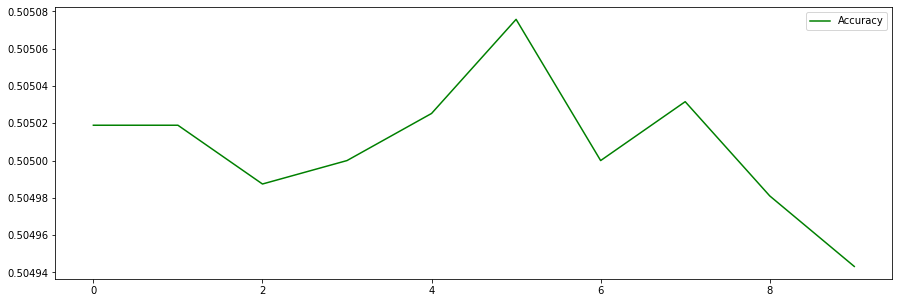

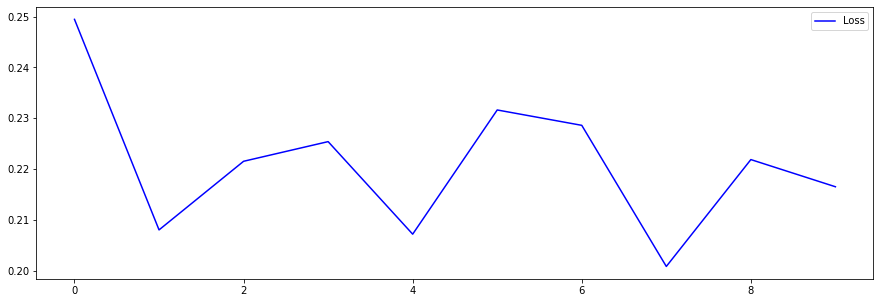

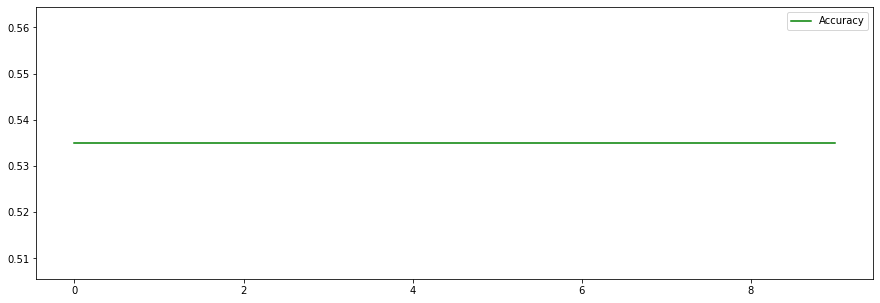

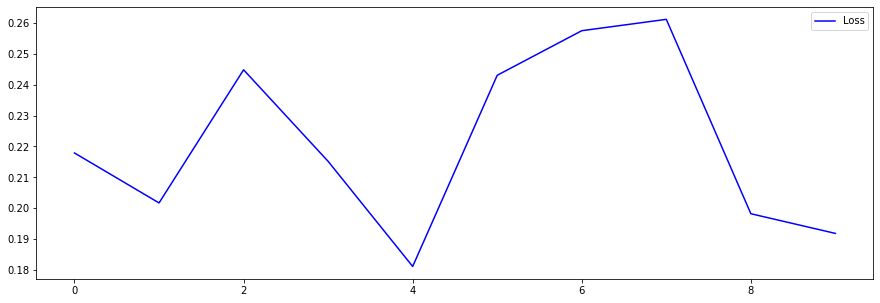

In [40]:
plt.figure(figsize=(15, 5))
plt.plot( accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot( loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 
    
plt.figure(figsize=(15, 5))
plt.plot( val_accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(val_loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 

In [41]:
lear = 0.005
batch_size = 50

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)


Epoch : 1, train accuracy : 0.5050780773162842, train loss : 0.38484299182891846
Epoch : 1, val_accuracy : 0.5349999666213989, val_loss : 0.30035918951034546


Epoch : 2, train accuracy : 0.5049999952316284, train loss : 0.7130606174468994
Epoch : 2, val_accuracy : 0.5349999666213989, val_loss : 0.6907669305801392


Epoch : 3, train accuracy : 0.5050780773162842, train loss : 0.6938932538032532
Epoch : 3, val_accuracy : 0.5349999666213989, val_loss : 0.6911046504974365


Epoch : 4, train accuracy : 0.505078136920929, train loss : 0.693518340587616
Epoch : 4, val_accuracy : 0.5349999666213989, val_loss : 0.6916248202323914


Epoch : 5, train accuracy : 0.5050260424613953, train loss : 0.6933113932609558
Epoch : 5, val_accuracy : 0.5349999666213989, val_loss : 0.6917307376861572


Epoch : 6, train accuracy : 0.5049217939376831, train loss : 0.6933320760726929
Epoch : 6, val_accuracy : 0.5349999666213989, val_loss : 0.6919081211090088


Epoch : 7, train accuracy : 0.5049479603767395, trai

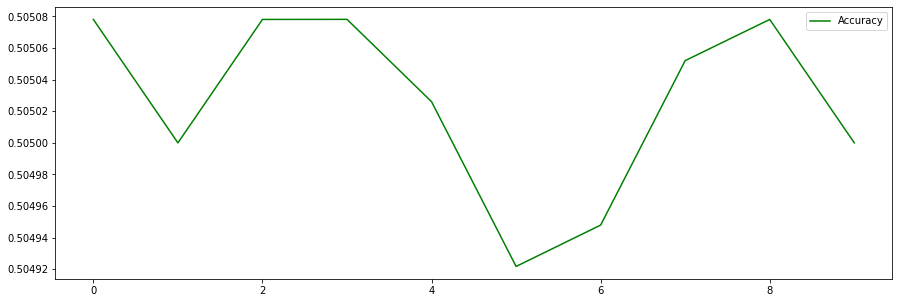

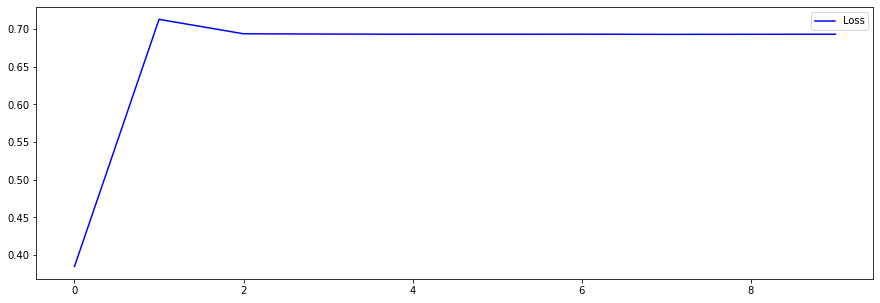

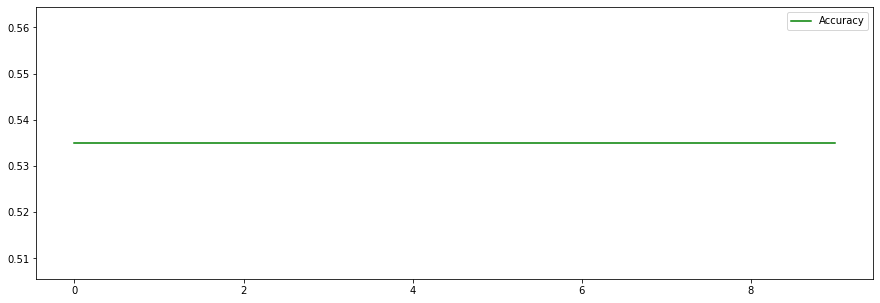

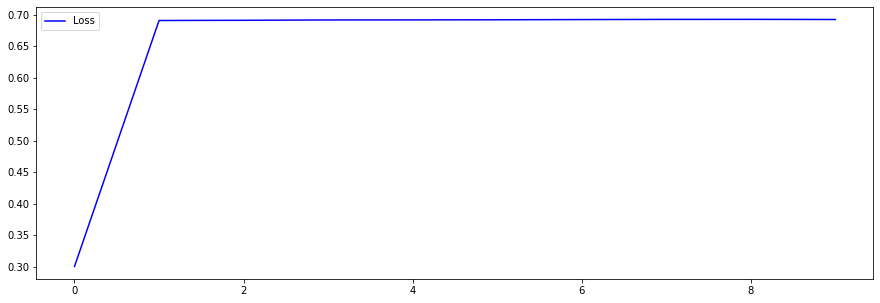

In [42]:
plt.figure(figsize=(15, 5))
plt.plot( accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot( loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 
    
plt.figure(figsize=(15, 5))
plt.plot( val_accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(val_loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 

In [43]:
lear = 0.005
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

Epoch : 1, train accuracy : 0.5049617290496826, train loss : 0.6013962030410767
Epoch : 1, val_accuracy : 0.5349999666213989, val_loss : 3.276538610458374


Epoch : 2, train accuracy : 0.5050637722015381, train loss : 0.9100081324577332
Epoch : 2, val_accuracy : 0.5349999666213989, val_loss : 0.6917678117752075


Epoch : 3, train accuracy : 0.5049234628677368, train loss : 0.6931645274162292
Epoch : 3, val_accuracy : 0.5349999666213989, val_loss : 0.6919077038764954


Epoch : 4, train accuracy : 0.5050127506256104, train loss : 0.6931519508361816
Epoch : 4, val_accuracy : 0.5349999666213989, val_loss : 0.692061185836792


Epoch : 5, train accuracy : 0.5050510168075562, train loss : 0.6931542158126831
Epoch : 5, val_accuracy : 0.5349999666213989, val_loss : 0.6922116279602051


Epoch : 6, train accuracy : 0.5050382614135742, train loss : 0.6931192278862
Epoch : 6, val_accuracy : 0.5349999666213989, val_loss : 0.6922435760498047


Epoch : 7, train accuracy : 0.5048851370811462, train los

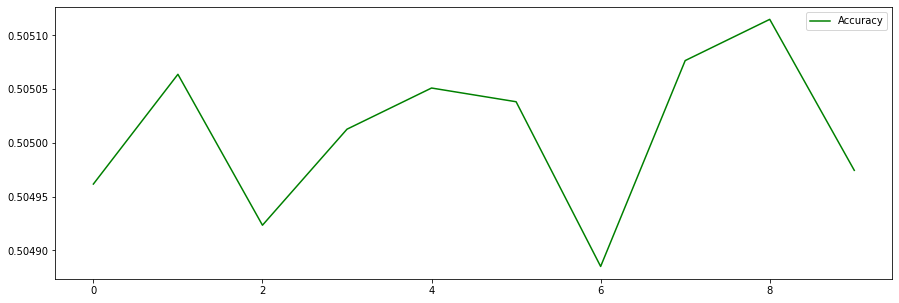

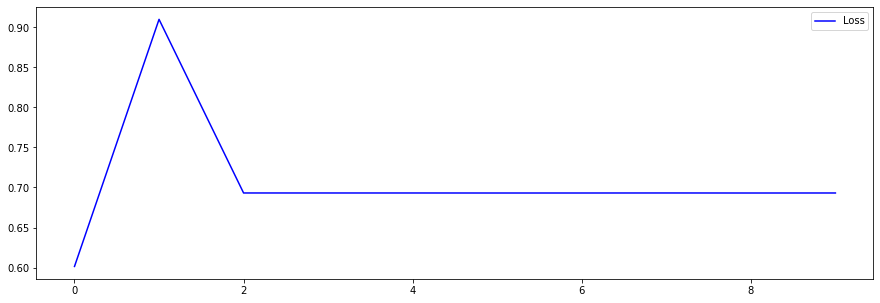

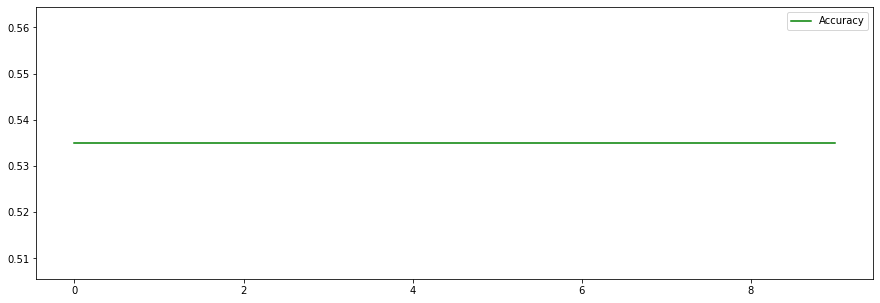

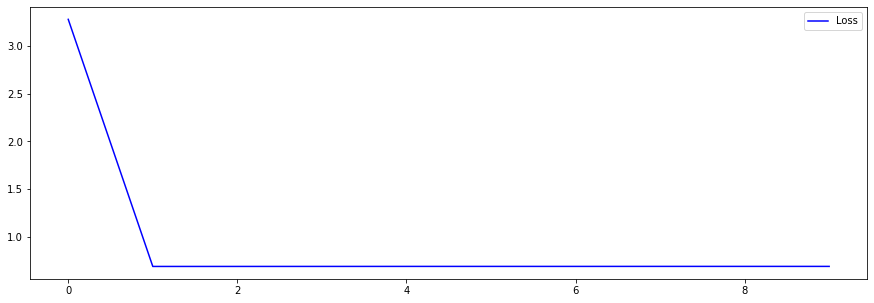

In [44]:
plt.figure(figsize=(15, 5))
plt.plot( accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot( loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 
    
plt.figure(figsize=(15, 5))
plt.plot( val_accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(val_loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 

In [45]:
lear = 0.005
batch_size = 200

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

Epoch : 1, train accuracy : 0.5049557685852051, train loss : 0.6178615093231201
Epoch : 1, val_accuracy : 0.5350000262260437, val_loss : 0.6494970917701721


Epoch : 2, train accuracy : 0.5050252676010132, train loss : 0.5826830267906189
Epoch : 2, val_accuracy : 0.5350000262260437, val_loss : 0.45200419425964355


Epoch : 3, train accuracy : 0.5050757527351379, train loss : 0.44641315937042236
Epoch : 3, val_accuracy : 0.5350000262260437, val_loss : 0.4204259216785431


Epoch : 4, train accuracy : 0.5049936771392822, train loss : 0.4228838384151459
Epoch : 4, val_accuracy : 0.5350000262260437, val_loss : 0.37642019987106323


Epoch : 5, train accuracy : 0.5050315260887146, train loss : 0.39386308193206787
Epoch : 5, val_accuracy : 0.5350000262260437, val_loss : 0.43246495723724365


Epoch : 6, train accuracy : 0.5049368739128113, train loss : 0.43900734186172485
Epoch : 6, val_accuracy : 0.5350000262260437, val_loss : 0.5306550860404968


Epoch : 7, train accuracy : 0.5050315856933594

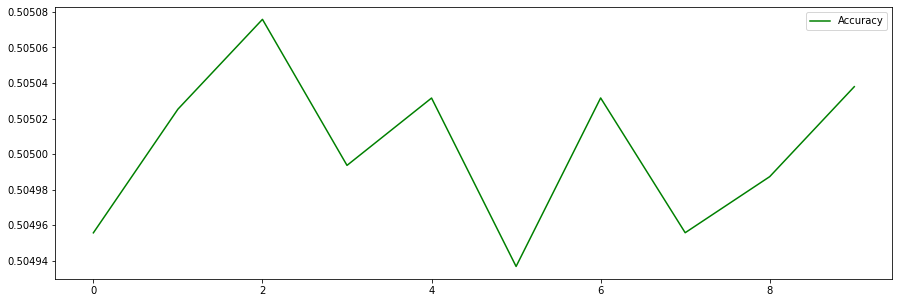

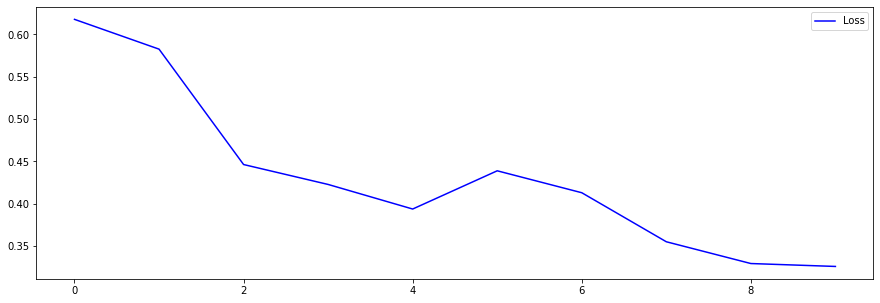

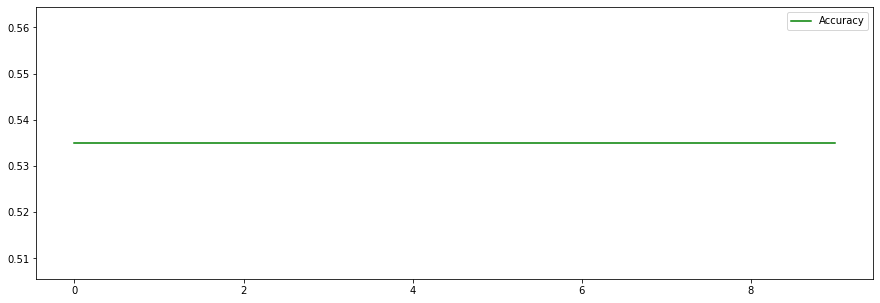

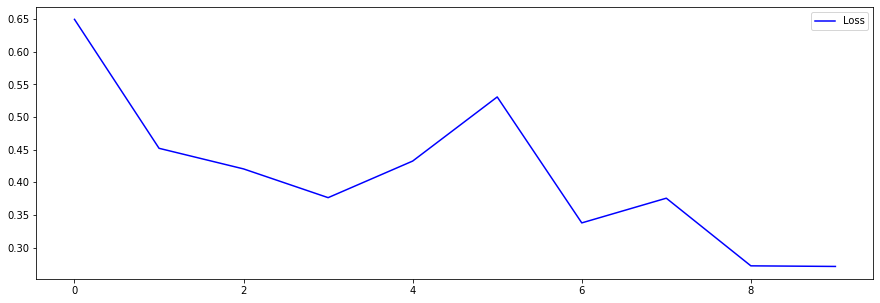

In [46]:
plt.figure(figsize=(15, 5))
plt.plot( accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot( loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 
    
plt.figure(figsize=(15, 5))
plt.plot( val_accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(val_loss_values, color="blue")
plt.legend(["Loss"])
plt.show() 

# Пункт 9
## Сохранение модели


In [49]:
torch.save(model.state_dict(), 'weight.pt')

# Пункт 10
## Повторная инициализация модели и загрузка весов

In [50]:
mymodel = Cnn()
mymodel.load_state_dict(torch.load("/content/weight.pt"))
mymodel.eval()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (re

In [51]:
test_loss = 0
test_accuracy = 0
    
for data, label in test_loader:
    data = data.to(device)
    label = label.to(device)

    output = mymodel(data)
    loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
    
    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).mean()
    test_accuracy += acc / len(test_loader)
    test_loss += float(loss.detach()) / len(test_loader)

In [52]:
print(test_accuracy, test_loss)

1.0 0.290924534201622


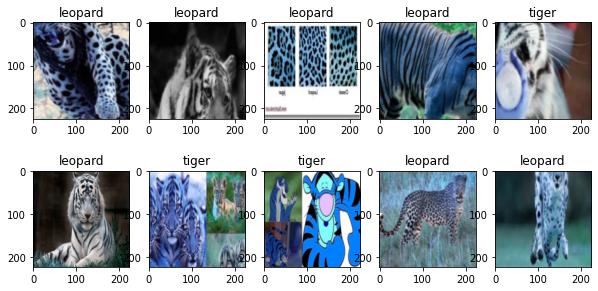

In [69]:
import random
plt.figure(figsize=(10, 5))

for j in range(10):
  index = random.randint(0, len(test_data))
  plt.subplot(2, 5, j + 1)
  plt.title("tiger" if (1 if  model(test_data[index][0].unsqueeze(dim=0))[0] >= 0.5 else 0) == 0 else "leopard")
  plt.imshow(test_data[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])